In [1]:
import numpy as np
from radial_constrained_cluster_copy import *
import matplotlib.pyplot as plt
import matplotlib
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from xarray import Dataset
from eofs.multivariate.standard import MultivariateEof
from shapely.geometry import mapping
from sklearn.cluster import KMeans
from scipy import signal
from obspy.signal.tf_misfit import cwt
import pymannkendall as mk
from tqdm import tqdm
from time import sleep

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
region_division = gpd.read_file('~/work/jacopo/DATA/regions/region_division.shp', crs="epsg:4326")
#region_division = world

import dask
dask.config.set(scheduler="synchronous")

from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

2022-10-03 20:54:35.444580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 20:54:35.583611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/Compiler/11.0/084/lib/intel64:/opt/intel/Compiler/11.0/084/mkl/lib/em64t
2022-10-03 20:54:35.583632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 20:54:35.611181: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

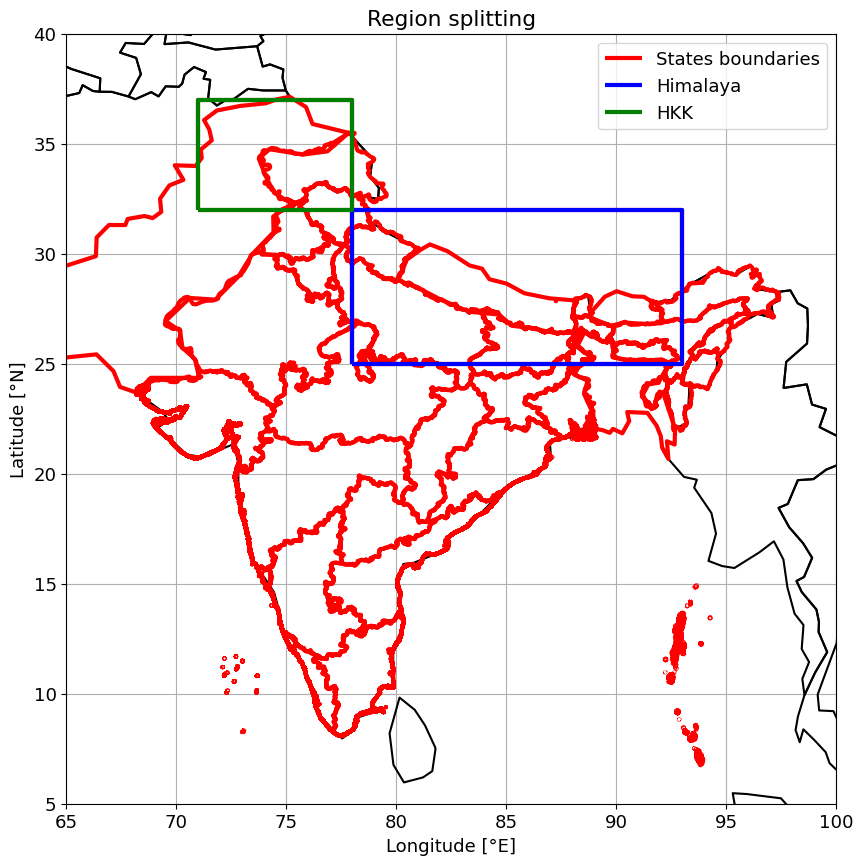

In [2]:
himalaya = Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])
himalaya = gpd.GeoDataFrame({'geometry': [Polygon([(78, 25), (93, 25), (93, 32), (78, 32)])]})
hkk = Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])
hkk = gpd.GeoDataFrame({'geometry': [Polygon([(71, 32), (78, 32), (78, 37), (71, 37)])]})

base = world.boundary.plot(figsize=(10,10), color = 'k')
region_division.boundary.plot(ax = base, color = 'r', linewidth=3, label = 'States boundaries')
himalaya.boundary.plot(ax = base, color = 'b', linewidth=3, label = 'Himalaya')
hkk.boundary.plot(ax = base, color = 'g', linewidth=3, label = 'HKK')

plt.xlim([65, 100])
plt.ylim([5, 40])
plt.grid()
plt.title('Region splitting')
plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')
plt.legend()

In [3]:
n_eof_comp = 20
n_reg = 5
add_coord = False
add_orog = False
do_detrend = False
orog_w = 0.1
coord_w = 0.25
fields = ['tp']


dataset = xr.open_dataset("~/work/jacopo/DATA/ERA5_prec_day_INDIA.nc").drop("time_bnds").rename(tp = 'tp')*24000
#dataset = dataset.sel(time=slice('1960','1970'))
#dataset = xr.open_dataset("DATA/APHRODITE_1951_2007_daily_INDIA.nc").drop('rstn').fillna(0)

#dataset = xr.open_mfdataset("/archive/paolo/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/historical/atmos/day/r1i1p1f1/pr/*.nc").rename(pr = 'tp').drop(['time_bnds','lat_bnds','lon_bnds'])*24000
#dataset = xr.open_mfdataset("/home/paolo/archive/cmip6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/ssp585/atmos/day/r1i1p1f1/pr/*.nc").rename(pr = 'tp').drop(['time_bnds','lat_bnds','lon_bnds'])*24000
#dataset = dataset.sel(lat=slice(5,40), lon=slice(65,100)).sel(time=slice('1980','2010')).load()
dataset = dataset.resample(time='1D').first()
dataset = dataset.sel(time=~((dataset['time.month'] == 2) & (dataset['time.day'] == 29)))
dataset = dataset.rolling(time=50, center=True).mean().fillna(0)

<Figure size 1000x1000 with 0 Axes>

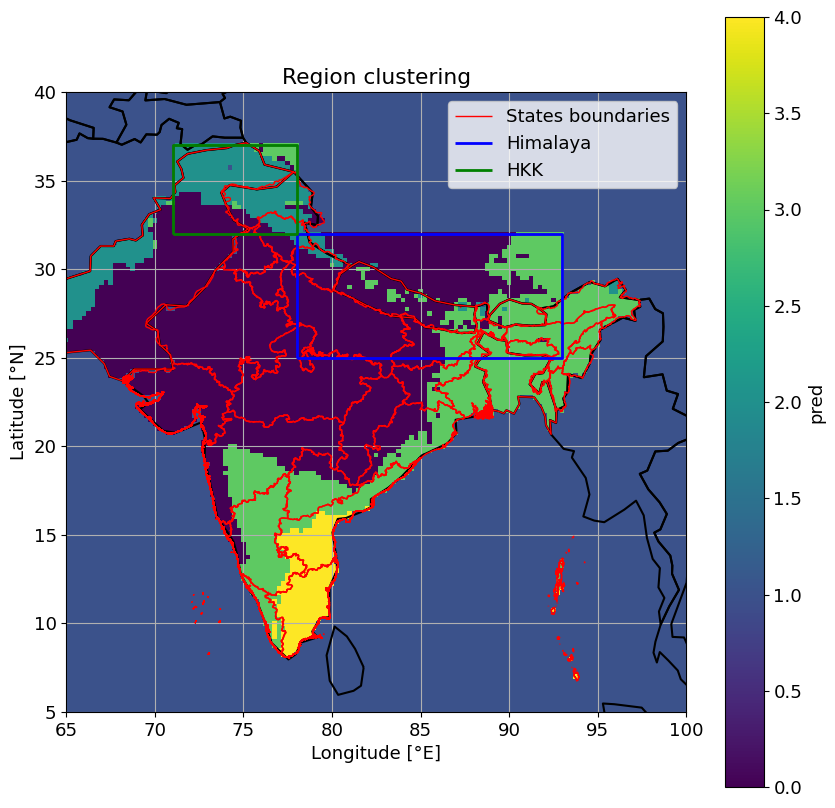

In [4]:

if do_detrend == True:
        dataset = detrend(dataset, 'tp', 'time', 1)

dataset_doy = dataset.groupby('time.dayofyear').mean().rename(dayofyear = 'time')

dataset_doy = dataset_doy.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset_doy = dataset_doy.rio.write_crs("epsg:4326", inplace=True)
dataset_doy = dataset_doy.rio.clip(region_division.geometry.apply(mapping), region_division.crs, drop=False)
dataset_doy = dataset_doy.fillna(1)

to_eof = []
for i in fields:
    supp = getattr(dataset_doy,i)
    supp = supp/supp.max('time')
    to_eof.append(supp.to_numpy())
 

to_fit = to_eof

old_shape = np.shape(to_fit)
new_shape = [np.size(to_fit, axis = 0)*np.size(to_fit, axis = 1), np.size(to_fit, axis = 2)*np.size(to_fit, axis = 3)]
to_fit = np.reshape(to_fit, new_shape)

if add_orog == True:
    supp = dataset.orog.mean('time')
    supp = (supp-supp.mean())/supp.std()
    supp = np.squeeze(supp.to_numpy()*orog_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)

if add_coord == True:
    la, lo = np.meshgrid(dataset.lon.to_numpy(),dataset.lon.to_numpy())
    la = (la-np.mean(la))/np.std(la)
    lo = (lo-np.mean(lo))/np.std(lo)

    supp = np.squeeze(la*coord_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)

    supp = np.squeeze(lo*coord_w)
    supp = np.transpose(supp.reshape(-1, 1))
    to_fit = np.concatenate((to_fit,supp), axis = 0)


to_fit = np.transpose(to_fit)


model = KMeans(n_clusters=n_reg, max_iter=300, random_state=1).fit(to_fit)
prediction = model.predict(to_fit)
pred = np.reshape(prediction,[old_shape[2], old_shape[3]])
pred =  pred.astype(float)
pred = xr.DataArray(pred).rename('pred').rename(dim_0='lat', dim_1='lon')

dataset = xr.merge([dataset, pred])


plt.figure(figsize = (10,10))

base = world.boundary.plot(figsize=(10,10), color = 'k')
axs = dataset.pred.plot(ax = base)
region_division.boundary.plot(ax = base, color = 'r', linewidth=1, label = 'States boundaries')
himalaya.boundary.plot(ax = base, color = 'b', linewidth=2, label = 'Himalaya')
hkk.boundary.plot(ax = base, color = 'g', linewidth=2, label = 'HKK')

plt.xlim([65, 100])
plt.ylim([5, 40])
plt.title('Region clustering')
plt.xlabel('Longitude [°E]')
plt.ylabel('Latitude [°N]')
plt.legend()
plt.grid()

Text(0, 0.5, 'PC 3')

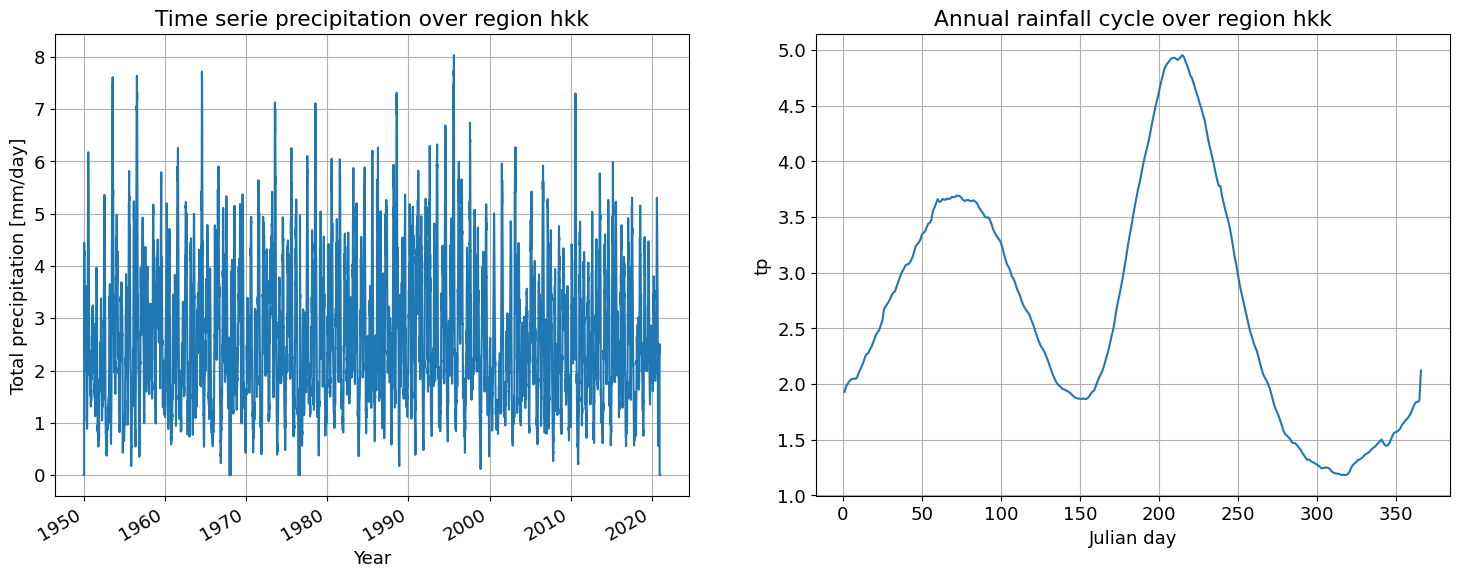

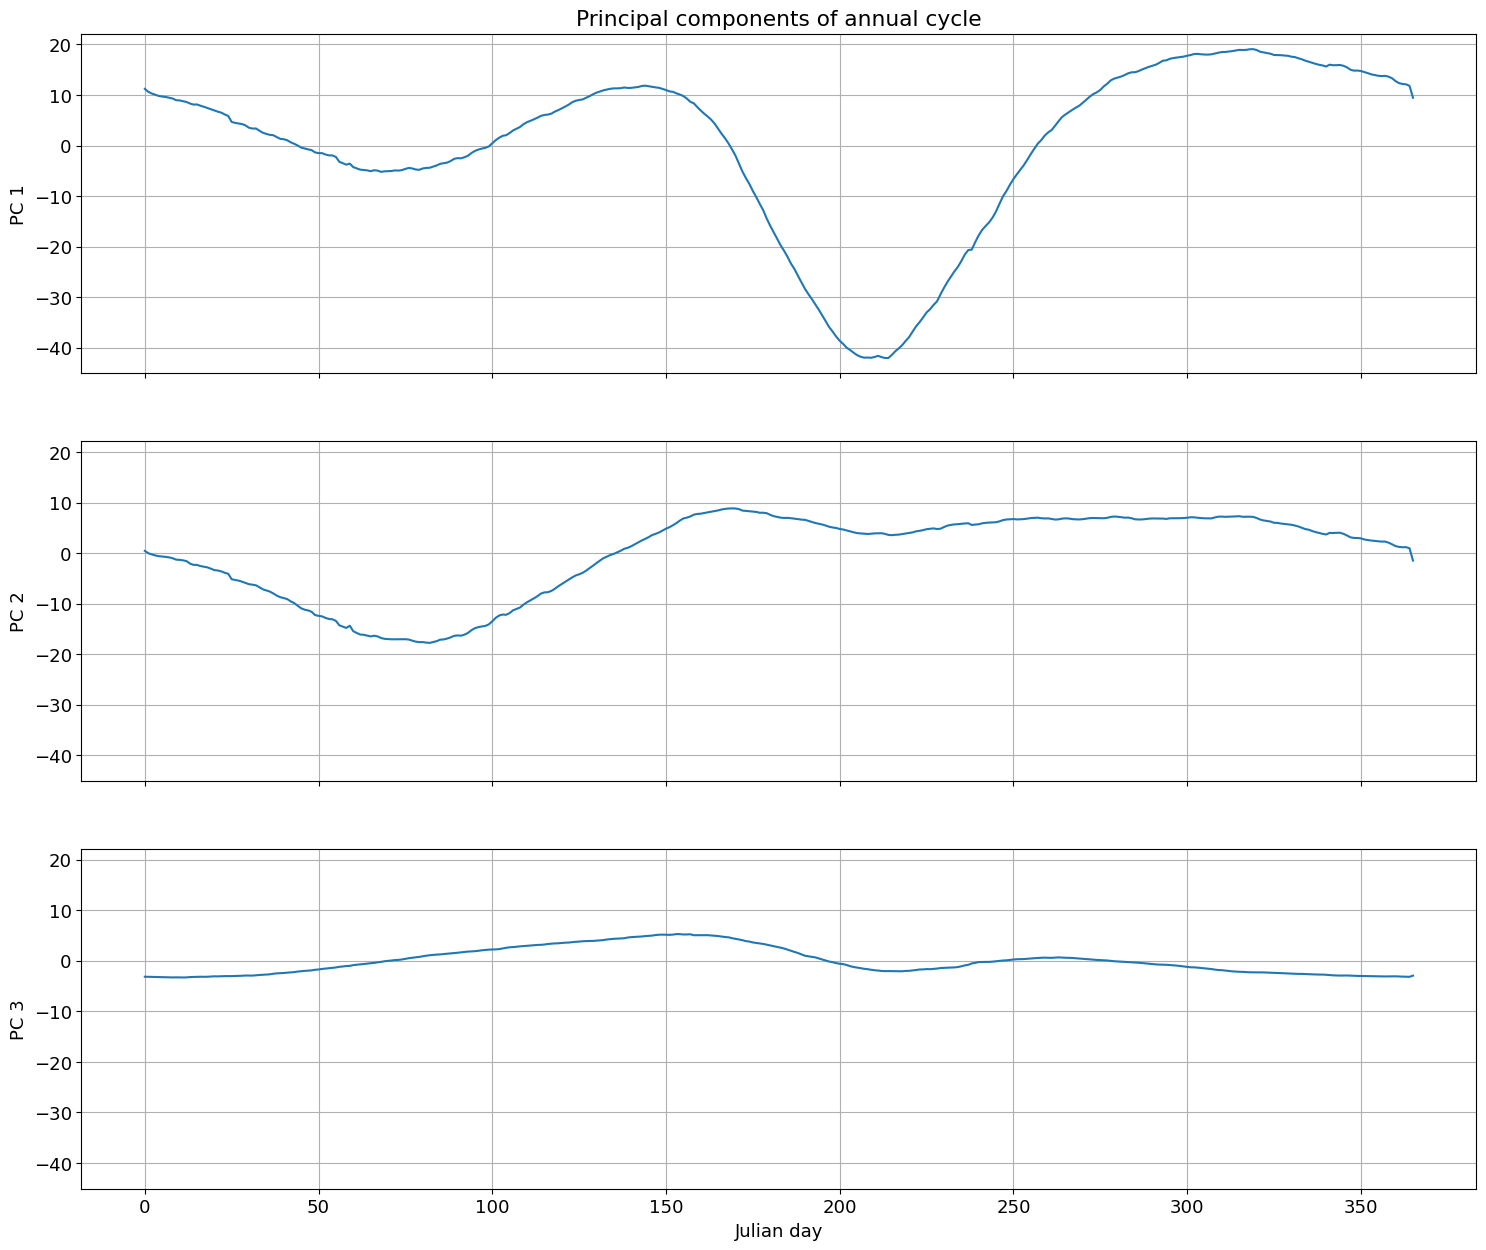

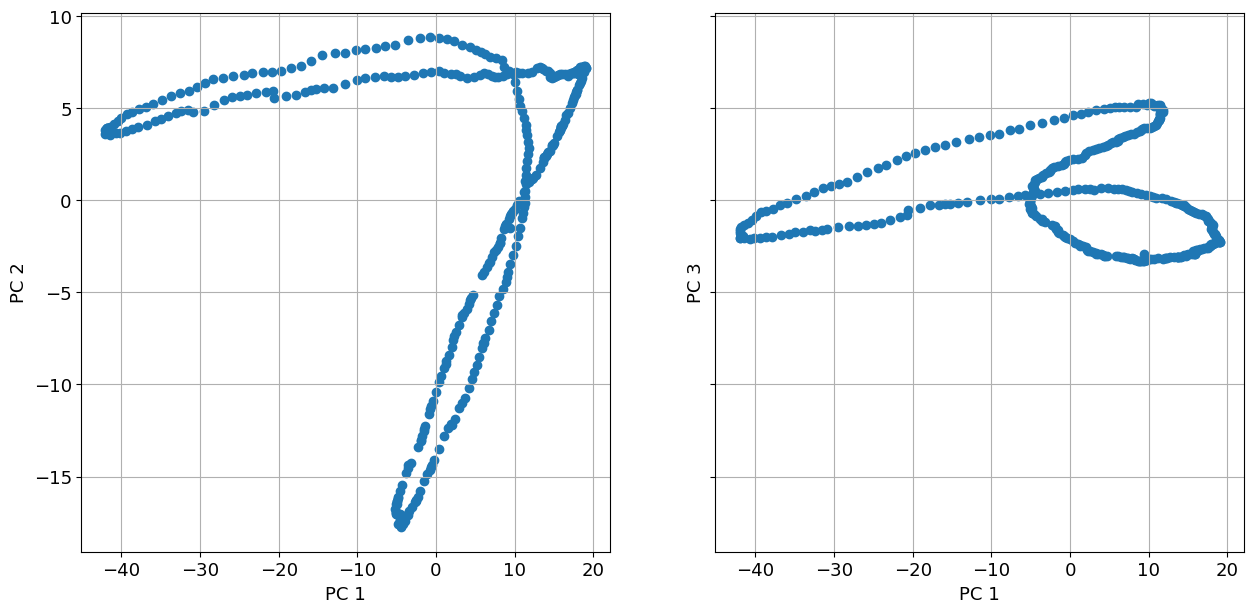

In [5]:
to_see = 'hkk'

if to_see == 'him':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True)
    data = data.rio.clip(himalaya.geometry.apply(mapping), himalaya.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
elif to_see == 'hkk':
    data = dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data = data.rio.write_crs("epsg:4326", inplace=True) 
    data = dataset.rio.clip(hkk.geometry.apply(mapping), hkk.crs, drop=False)
    data_doy = data.groupby('time.dayofyear').mean()
    
else:
    data = dataset.where(dataset.pred == to_see)
    data_doy = dataset_doy.where(dataset.pred == to_see)
    
    
fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = False)
data.tp.mean(['lat','lon']).plot(ax=axs[0])
axs[0].set_title(f'Time serie precipitation over region {to_see}')
axs[0].grid()
axs[0].set_ylabel('Total precipitation [mm/day]')
axs[0].set_xlabel('Year')

data_doy.tp.mean(['lat','lon']).plot(ax=axs[1])
axs[1].set_title(f'Annual rainfall cycle over region {to_see}')
axs[1].set_xlabel('Julian day')
axs[1].grid()

###################################################################
data_to_train = data.sel(time=slice('1950','2000'))
data_to_train_doy = data_to_train.groupby('time.dayofyear').mean()
data_to_train = data_to_train.drop('spatial_ref')

data_to_val = data.sel(time=slice('1980','1990'))
data_to_val_doy = data_to_val.groupby('time.dayofyear').mean()
data_to_val = data_to_val.drop('spatial_ref')
###################################################################


to_eof = []
for i in fields:
    supp = getattr(data_to_train_doy,i)
    supp = (supp-supp.mean())/supp.std()
    to_eof.append(supp.to_numpy())

solver = MultivariateEof(to_eof)
pc = solver.pcs(npcs = n_eof_comp)

fig, axs = plt.subplots(3,1, figsize = (18,15), sharex = True, sharey=True)
axs[0].plot(pc[:,0])
axs[0].set_title('Principal components of annual cycle')
axs[0].grid()
axs[0].set_ylabel('PC 1')

axs[1].plot(pc[:,1])
axs[1].set_ylabel('PC 2')
axs[1].grid()

axs[2].plot(pc[:,2])
axs[2].set_xlabel('Julian day')
axs[2].set_ylabel('PC 3')
axs[2].grid()

fig, axs = plt.subplots(1,2, figsize = (15,7), sharey = True, sharex=True)
axs[0].scatter(pc[:,0],pc[:,1])
axs[0].grid()
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

axs[1].scatter(pc[:,0],pc[:,2])
axs[1].grid()
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 3')

Final error: 6304.97281429215
Breakpoints: [ 57 223 273 363]


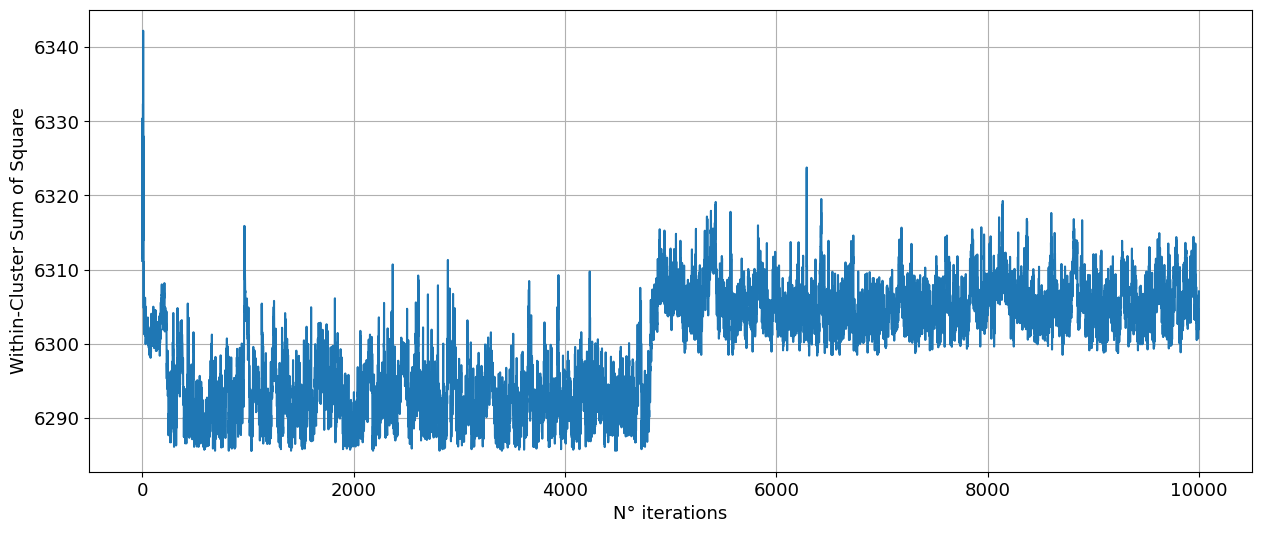

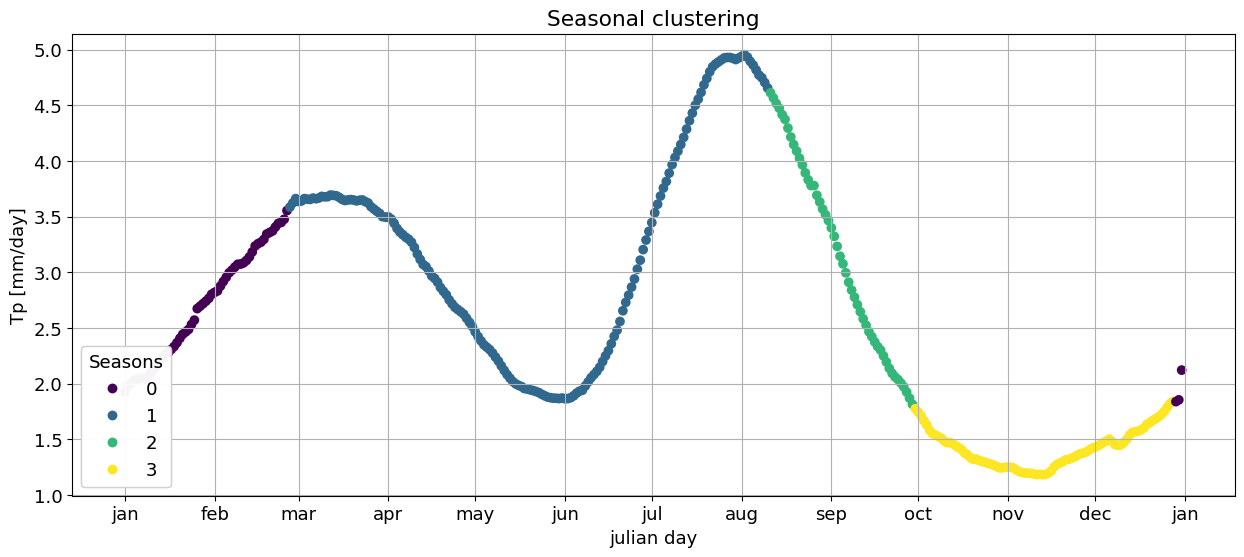

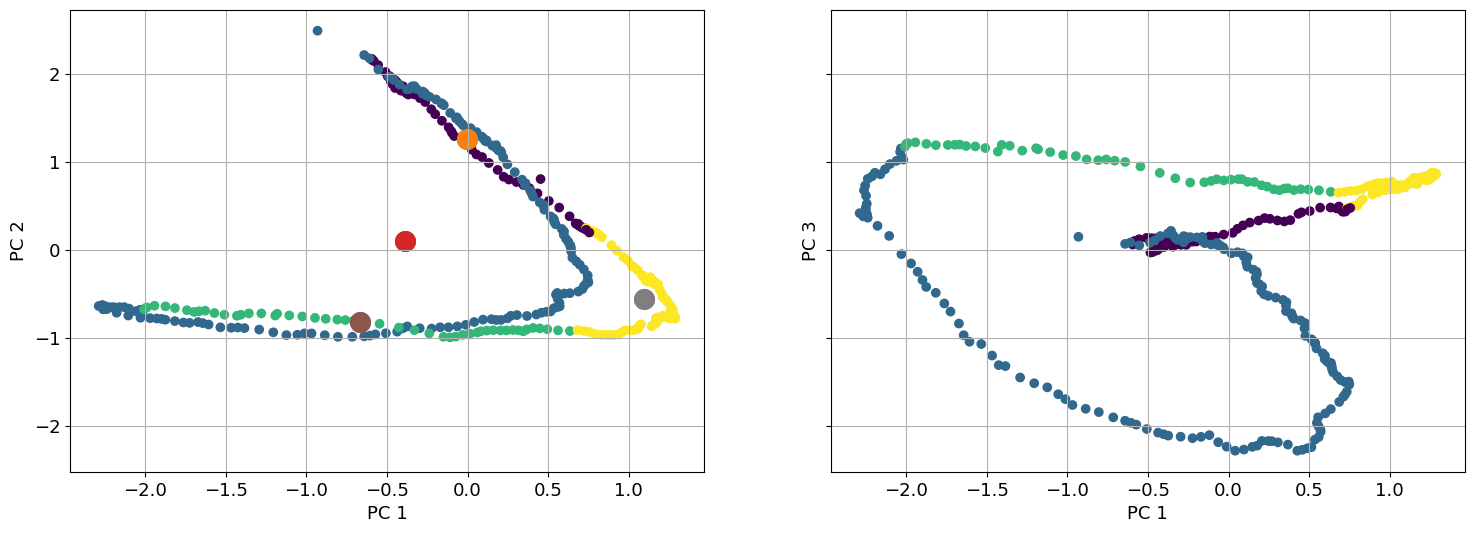

In [36]:
len_consistancy_check = True
min_len = 10

learning_rate = 20
scheduling_factor = 2
l_r_scheduler = True

n_iter = 10000

n_seas = 4


model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)

model.fit()
prediction = model.get_prediction()


plt.figure(figsize = (15,6))
plt.plot(model.error_story)
plt.grid()
plt.xlabel('N° iterations')
plt.ylabel('Within-Cluster Sum of Square')

cc = model.get_centroids()
print(f'Final error: {model.get_final_error()}')
print(f'Breakpoints: {model.breakpoints}')

fig, ax = plt.subplots(figsize = (15,6))
scatter = ax.scatter(range(np.size(pc, axis=0)), data_doy.tp.mean(['lat','lon']), c = prediction)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Seasons")
ax.set_title('Seasonal clustering')
ax.add_artist(legend1)
ax.grid()
ax.set_xlabel('julian day')
ax.set_ylabel('Tp [mm/day]')
ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])


fig, axs = plt.subplots(1,2, figsize = (18,6), sharey = True, sharex=True)
axs[0].scatter(pc[:,0],pc[:,1], c = prediction )
for i in range(n_seas):
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
    axs[0].scatter(cc[i][0],cc[i][1], s = 200)
axs[0].grid()
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

axs[1].scatter(pc[:,0],pc[:,2], c = prediction)
axs[1].grid()
axs[1].set_xlabel('PC 1')
axs[1].set_ylabel('PC 3')


to_eof = []
for i in fields:
    supp = getattr(data_to_train,i)
    supp = (supp-supp.mean())/supp.std()
    to_eof.append(supp.to_numpy())

solver = MultivariateEof(to_eof)
pc_train = solver.pcs(npcs = n_eof_comp)
#pc_train = np.append(pc_train, np.reshape(np.repeat(range(0,365),51),(365*51,1)),axis = 1)
pc_train = np.append(pc_train, np.reshape(np.sin(20*np.linspace(0,51*np.pi,51*365)),(365*51,1)),axis = 1)
pc_train = np.append(pc_train, np.reshape(np.cos(20*np.linspace(0,51*np.pi,51*365)),(365*51,1)),axis = 1)

pc_train = (pc_train - pc_train.mean(axis=0))/pc_train.std(axis=0)

y_train = np.repeat(prediction[0:-1],51)

#pc_train = pc[0:365]
#pc_train = (pc_train - pc_train.mean(axis=0))/pc_train.std(axis=0)
#pc_train = np.append(pc_train, np.reshape(np.sin(np.linspace(0,2*np.pi,365)),(365,1)),axis = 1)
#pc_train = np.append(pc_train, np.reshape(np.cos(np.linspace(0,2*np.pi,365)),(365,1)),axis = 1)
#pc_train = np.append(pc_train, np.reshape(range(0,365),(365,1)),axis = 1)
#y_train = prediction

In [37]:
input = layers.Input(shape=(n_eof_comp+2))

# Encoder
x = layers.Dense(6, activation='relu')(input)
x = layers.Dense(12, activation='relu')(x)
x = layers.Dense(n_seas, activation='softmax')(x)


# Autoencoder
lstm_net = Model(input, x)
lstm_net.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics='accuracy')
lstm_net.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_18 (Dense)            (None, 6)                 138       
                                                                 
 dense_19 (Dense)            (None, 12)                84        
                                                                 
 dense_20 (Dense)            (None, 4)                 52        
                                                                 
Total params: 274
Trainable params: 274
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
117/117 [==============================] - 1s 4ms/step - loss: 1.3916 - accuracy: 0.3758 - val_loss: 2.3959 - val_accuracy: 0.0000e+00
Epoch 2/100
117/117 [==============================] - 0s 3ms/step - loss: 1.1242 - accuracy: 0.5585 - val_loss: 2.7186 - val_accuracy: 0.0000e+00
Epoch 3/100
117/117 [==============================] - 0s 4ms/step - loss: 1.0421 - accuracy: 0.5710 - val_loss: 2.9126 - val_accuracy: 0.0000e+00
Epoch 4/100
117/117 [==============================] - 0s 4ms/step - loss: 0.9835 - accuracy: 0.5889 - val_loss: 3.0987 - val_accuracy: 0.0021
Epoch 5/100
117/117 [==============================] - 0s 4ms/step - loss: 0.9333 - accuracy: 0.6074 - val_loss: 3.2531 - val_accuracy: 0.0073
Epoch 6/100
117/117 [==============================] - 0s 4ms/step - loss: 0.8950 - accuracy: 0.6215 - val_loss: 3.2991 - val_accuracy: 0.0204
Epoch 7/100
117/117 [==============================] - 1s 4ms/step - loss: 0.8647 - accuracy: 0.6311 - val_loss: 3.3351 - val_accu

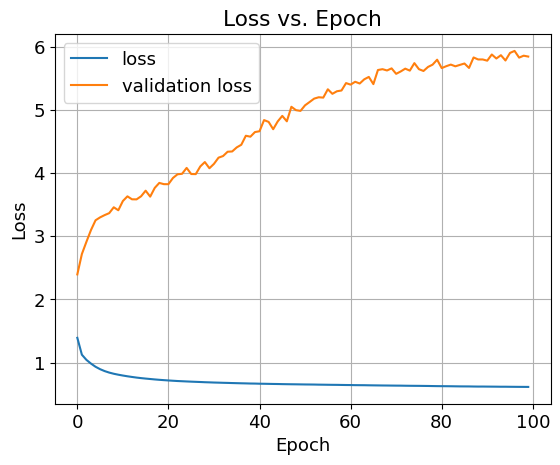

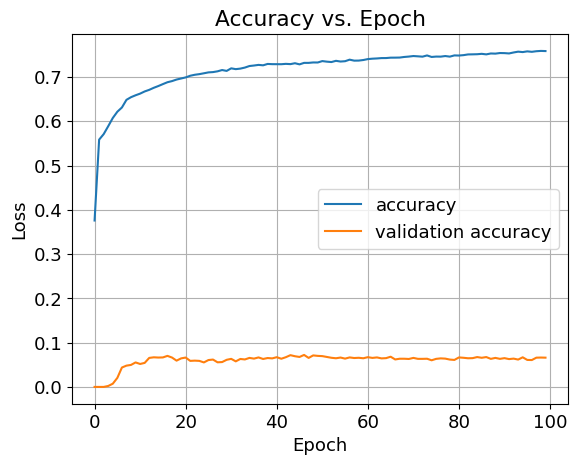

In [38]:
pc_traine = timeseries_dataset_from_array(
    pc_train,
    y_train,
    sequence_length=15,
    sampling_rate=1,
    batch_size=10,
)

model_history = lstm_net.fit(
    x=pc_train,
    y=y_train,
    epochs=100,
    batch_size=128,
#    validation_data = pc_vale,
    validation_split = 0.2,
    shuffle=True
)

plt.figure()
plt.plot(model_history.history["loss"], label='loss')
plt.plot(model_history.history["val_loss"], label='validation loss')
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)


plt.figure()
plt.plot(model_history.history["accuracy"], label='accuracy')
plt.plot(model_history.history["val_accuracy"], label='validation accuracy')
plt.title("Accuracy vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

  0%|          | 0/2 [00:00<?, ?it/s]

12/12 [==============================] - 0s 2ms/step


 50%|█████     | 1/2 [00:11<00:11, 11.27s/it]

12/12 [==============================] - 0s 1ms/step


100%|██████████| 2/2 [00:21<00:00, 10.84s/it]


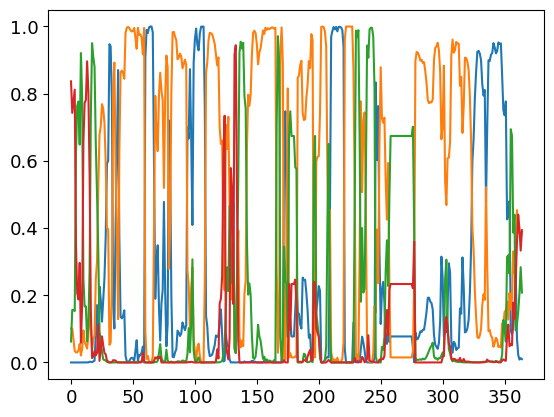

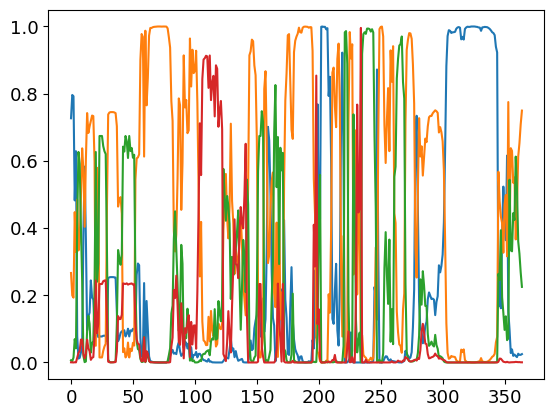

In [41]:
p = []

for i in tqdm(np.arange(1,10,5)):

    plt.figure()
    sleep(3)
    data_to_test = data.sel(time=slice(str(1990+i),str(1995+i)))
    data_to_test_doy = data_to_test.groupby('time.dayofyear').mean()

    to_eof = []
    for i in fields:
        supp = getattr(data_to_test_doy,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())

    solver = MultivariateEof(to_eof)
    pc_test = solver.pcs(npcs = n_eof_comp)
    pc_test = pc_test[0:365]
    #pc_test = np.append(pc_test, np.reshape(range(0,365),(365,1)),axis = 1)
    
    
    pc_test = np.append(pc_test, np.reshape(np.sin(20*np.linspace(0,np.pi,365)),(365,1)),axis = 1)
    pc_test = np.append(pc_test, np.reshape(np.cos(20*np.linspace(0,np.pi,365)),(365,1)),axis = 1)
    pc_test = (pc_test-pc_test.mean(axis=0))/pc_test.std(axis=0)

    model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)

    model.fit()
    prediction = model.get_prediction()
    y_test = prediction


    pc_teste = timeseries_dataset_from_array(
        pc_test,
        y_train,
        sequence_length=15,
        sampling_rate=1,
        batch_size=100,
        )

    pred_season = lstm_net.predict(pc_test)
    p.append(pred_season)

    plt.plot(range(0,len(pred_season)),pred_season)


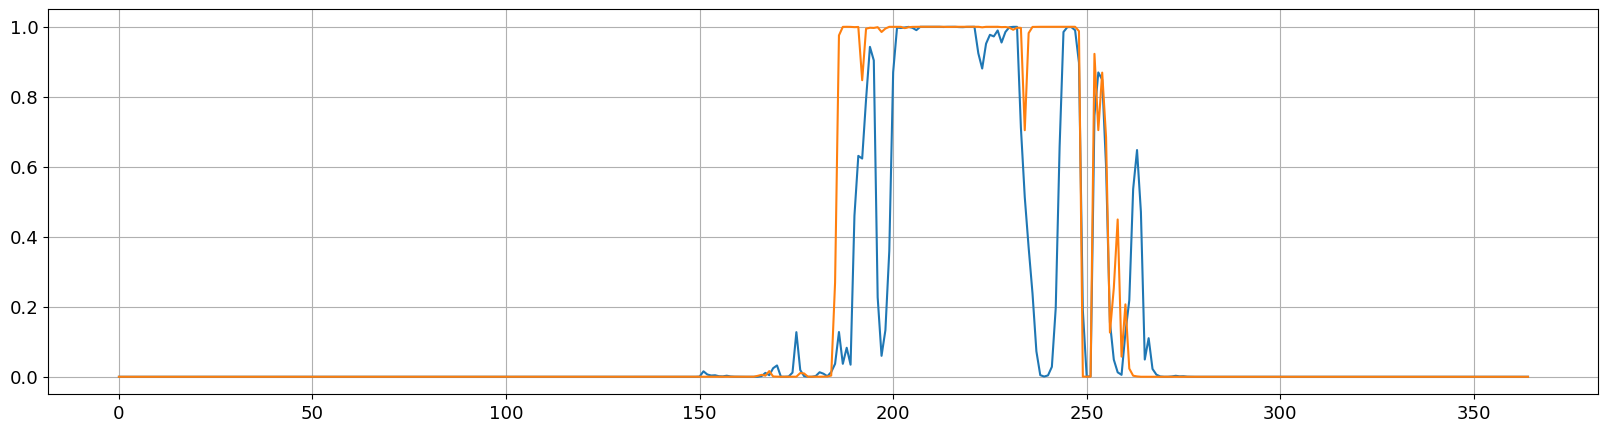

In [28]:
plt.figure(figsize=(20,5))
for i in range(len(p)):
    plt.plot(p[i][:,2])

plt.grid()

([<matplotlib.axis.XTick at 0x7fa53441a620>,
 [Text(0, 0, 'jan'),
  Text(31, 0, 'feb'),
  Text(60, 0, 'mar'),
  Text(91, 0, 'apr'),
  Text(121, 0, 'may'),
  Text(152, 0, 'jun'),
  Text(182, 0, 'jul'),
  Text(213, 0, 'aug'),
  Text(244, 0, 'sep'),
  Text(274, 0, 'oct'),
  Text(305, 0, 'nov'),
  Text(335, 0, 'dec'),
  Text(366, 0, 'jan')])

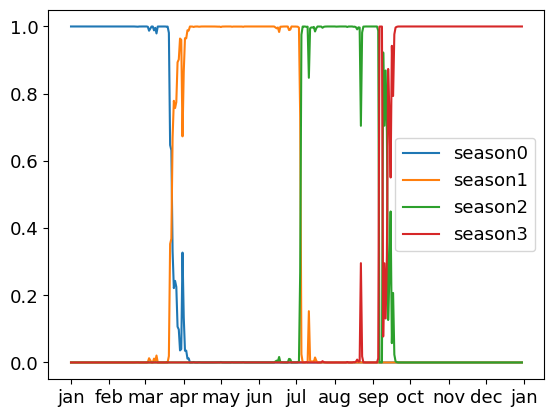

In [29]:
for i in range(n_seas):
    plt.plot(pred_season[:,i], label = f'season{i}')

plt.legend()
plt.xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])

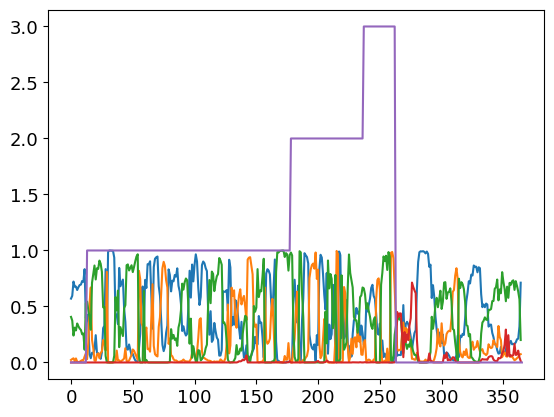

In [13]:
plt.plot(range(0,len(pred_season)),pred_season)
plt.plot(range(0,len(y_test)),y_test)

In [14]:
for i in tqdm(range(3)):

    plt.figure()
    sleep(3)
    data_to_test = data.sel(time=slice(str(2000+i),str(2015+i)))
    data_to_test_doy = data_to_test.groupby('time.dayofyear').mean()

    to_eof = []
    for i in fields:
        supp = getattr(data_to_test_doy,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())

    solver = MultivariateEof(to_eof)
    pc = solver.pcs(npcs = n_eof_comp)

    model = Radially_Constrained_Cluster(pc, n_seas, n_iter, 
                                learning_rate, l_r_scheduler, scheduling_factor, 
                                len_consistancy_check, min_len)

    model.fit()
    prediction = model.get_prediction()
    y_test = np.repeat(prediction[0:-1],16)



    to_eof = []
    for i in fields:
        supp = getattr(data_to_test,i)
        supp = (supp-supp.mean())/supp.std()
        to_eof.append(supp.to_numpy())

    solver = MultivariateEof(to_eof)
    pc_test = solver.pcs(npcs = n_eof_comp)
    pc_test = np.append(pc_test, np.reshape(np.repeat(range(0,365),16),(365*16,1)),axis = 1)

    pc_teste = timeseries_dataset_from_array(
        pc_test,
        y_train,
        sequence_length=15,
        sampling_rate=1,
        batch_size=1000,
        )

    pred_season = lstm_net.predict(pc_teste).argmax(-1)

    plt.plot(range(0,len(pred_season)),pred_season)
    plt.plot(range(0,len(y_test)),y_test)

  0%|          | 0/3 [00:07<?, ?it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>